# TXS 0506+056

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import astropy.units as u
from astropy.coordinates import SkyCoord

## Source info

In [2]:
# A TXS-like source (see IceCube et al. 2018)
txs_coords = SkyCoord(ra=77.36 * u.deg, dec=5.69 * u.deg, frame="icrs")
txs_z = 0.3365
#txs_Emin = (200 * u.TeV).to(u.GeV)
#txs_Emax = (7.5 * u.PeV).to(u.GeV) 
txs_Emin = (10 * u.TeV).to(u.GeV)
txs_Emax = (1000 * u.PeV).to(u.GeV) 

# An IC170922-like event + nu observations
ic_Edet = (23.7 * u.TeV).to(u.GeV) # IceCube et al. 2018

ic_Emin_det = (20 * u.TeV).to(u.GeV)

#ic_src_index = 2.13 # IceCube et al. 2018 
#ic_L = 2.1e46 
#ic_L = 3e45 * (u.erg/u.s) # Value from ps constraints (flux_norm @ 100 TeV ~ 5e-16 1/(GeVms))
ic_L = 5e46 * (u.erg / u.s) # Nex_src ~ 1
ic_src_index = 2.0

ic_diff_norm = (2e-18 * 4 * np.pi * (1 / (u.GeV * u.cm**2 * u.s))).to(1/(u.GeV * u.m**2 * u.s))
ic_diff_index = 2.6
ic_T = 0.5 * u.year
ic_ang_res = 0.7 * u.deg
ic_ra = 77.43 * u.deg # GCN 21916 (-0.80 deg/+1.30 deg 90% PSF containment)
ic_dec = 5.79 * u.deg # GCN 21916 (-0.40 deg/+0.70 deg 90% PSF containment) 

In [3]:
from hierarchical_nu.source.parameter import Parameter
from hierarchical_nu.source.source import Sources, PointSource

In [4]:
# Define parameters
Parameter.clear_registry()

flux_units = 1/(u.GeV * u.m**2 * u.s)

src_index = Parameter(ic_src_index, "src_index", fixed=False, par_range=(1, 4))
diff_index = Parameter(ic_diff_index, "diff_index", fixed=False, par_range=(1, 4))
L = Parameter(ic_L, "luminosity", fixed=True, 
              par_range=(0, 1e60)*(u.erg/u.s))
diffuse_norm = Parameter(ic_diff_norm, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf)*flux_units)
Enorm = Parameter(1e5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(txs_Emin, "Emin", fixed=True)
Emax = Parameter(txs_Emax, "Emax", fixed=True)
Emin_src = Parameter(Emin.value * (1 + txs_z), "Emin_src", fixed=True)
Emax_src = Parameter(Emax.value * (1 + txs_z), "Emax_src", fixed=True)
Emin_diff = Parameter(Emin.value, "Emin_diff", fixed=True)
Emax_diff = Parameter(Emax.value, "Emax_diff", fixed=True)

Emin_det = Parameter(ic_Emin_det, "Emin_det", fixed=True)

In [5]:
from hierarchical_nu.detector.input import mceq

In [6]:
# Define sources
point_source = PointSource.make_powerlaw_source("test", txs_coords.dec.to(u.rad),
                                                txs_coords.ra.to(u.rad), 
                                                L, src_index, txs_z, Emin_src, Emax_src)

my_sources = Sources()
my_sources.add(point_source)

# auto diffuse component 
my_sources.add_diffuse_component(diffuse_norm, Enorm.value, diff_index, Emin_diff, Emax_diff) 
my_sources.add_atmospheric_component(cache_dir=mceq) # auto atmo component

Text(0, 0.5, 'dN/dE [Gev^-1 cm^-2 s^-1]')

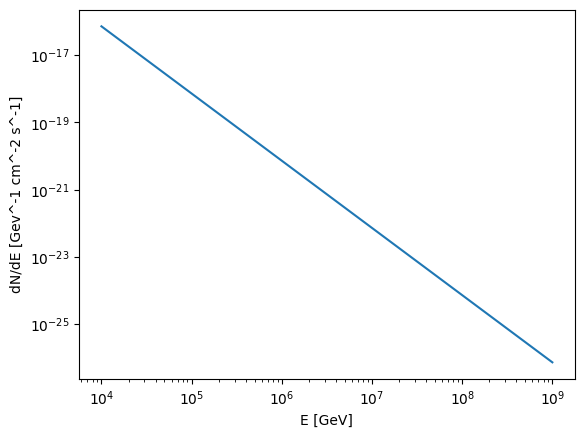

In [7]:
energy_range = np.logspace(np.log10(Emin.value.to(u.GeV).value), np.log10(Emax.value.to(u.GeV).value), 100) * u.GeV

powerlaw_spectrum = my_sources.point_source[0].flux_model.spectral_shape

fig, ax = plt.subplots()
ax.plot(energy_range.to_value(u.GeV), powerlaw_spectrum(energy_range).to_value(1 / (u.GeV * u.cm**2 * u.s)))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [GeV]")
ax.set_ylabel("dN/dE [Gev^-1 cm^-2 s^-1]")

In [8]:
powerlaw_spectrum._upper_energy

<Quantity 1.e+09 GeV>

In [9]:
point_source.flux_model._spectral_shape._parameters["norm"]

Parameter test_norm = 7.191256109948886e-15 1 / (GeV s m2), fixed = True

In [10]:
my_sources.f_arr() # Associated fraction of arrival flux

<Quantity 0.00069619>

In [11]:
my_sources.f_arr_astro() # As above, excluding atmo

<Quantity 0.01136881>

## ROI

In [12]:
from hierarchical_nu.utils.roi import CircularROI

In [13]:
roi = CircularROI(txs_coords, 5 * u.deg, apply_roi=True)

## Simulation

In [14]:
from hierarchical_nu.simulation import Simulation
from hierarchical_nu.detector.icecube import IC86_II

/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
obs_time = ic_T

sim = Simulation(my_sources, IC86_II, obs_time)
#sim = Simulation(my_sources, IceCubeDetectorModel, obs_time)

In [16]:
sim.precomputation()
sim.generate_stan_code()
#sim.set_stan_filename(".stan_files/sim_code_asimov.stan")
sim.compile_stan_code()

13:55:07 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/sim_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/sim_code
13:55:27 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/caba/examples/.stan_files/sim_code


In [17]:
sim.run(verbose=True, seed=173) 
sim.save("txs_sim.h5", overwrite=True)
#sim.save("output/test_sim.h5")

13:55:27 - cmdstanpy - INFO - CmdStan start processing


Running a simulation with expected Nnu = 1.88 events


chain 1 |███████████████████████████████████████████████████| 00:00 Sampling completed


13:55:27 - cmdstanpy - INFO - CmdStan done processing.


PosixPath('/home/iwsatlas1/caba/examples/txs_sim.h5')

In [18]:
sim._expected_Nnu_per_comp

array([1.63302929, 0.04450764, 0.19806281])

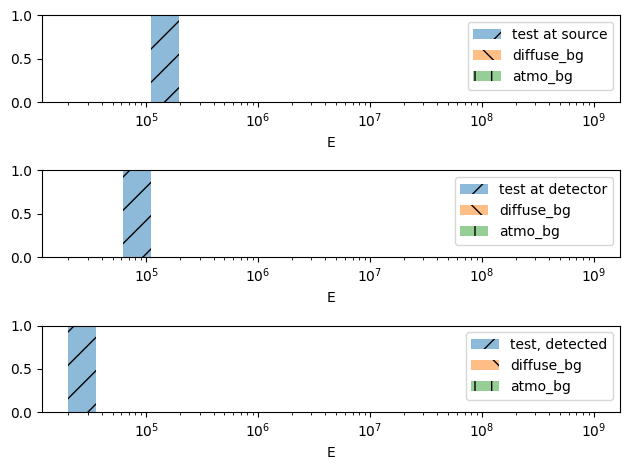

In [19]:
fig, ax = sim.show_spectrum()
fig.tight_layout()

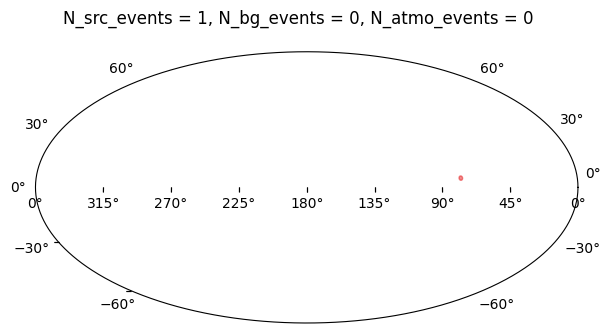

In [20]:
fig, ax = sim.show_skymap()

In [21]:
sim.events.energies

<Quantity [21037.3] GeV>

## Fit

In [22]:
from hierarchical_nu.events import Events
from hierarchical_nu.fit import StanFit
from hierarchical_nu.priors import Priors, LogNormalPrior, NormalPrior, FluxPrior, LuminosityPrior, IndexPrior, DifferentialFluxPrior

In [23]:
events = Events.from_file("txs_sim.h5") 
#events = sim.events
obs_time = ic_T

In [24]:
# Different prior means to try

L_prior_mean = 1e49 * (u.GeV / u.s)
L_prior_width = 3
src_index_prior_mean = 2.0
src_index_prior_width = 0.1

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
#diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
#priors.diffuse_flux = DifferentialFluxPrior(LogNormalPrior, mu=ic_diff_norm, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)
priors.src_index = IndexPrior(mu=src_index_prior_mean, sigma=src_index_prior_width)

In [25]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)
#fit = StanFit(my_sources, IceCubeDetectorModel, events, obs_time, priors=priors, nshards=0)

In [26]:
import time

In [27]:
fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()
start_time = time.time()
fit.run(show_progress=True, show_console=True, seed=9856845, iterations=1000, iter_warmup=1000, chains=4)
time_taken = time.time() - start_time

13:55:48 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
13:56:13 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/caba/examples/.stan_files/model_code
13:56:13 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /tmp/tmprtgpod0w/dqlxf_zk.json
init = 2 (Default)
random
seed = 9856845
output
file = /tmp/tmprtgpod0w/model_codex_99j5_e/model_code-20240926135613.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (Default)


Gradient evaluation took 0.000112 seconds
1000 transitions using 10 leapf

13:56:14 - cmdstanpy - INFO - CmdStan done processing


Chain [2] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [2] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.435 seconds (Warm-up)
0.495 seconds (Sampling)
0.93 seconds (Total)




In [28]:
time_taken

1.0081171989440918

In [29]:
fit._fit_output.diagnose()

'Processing csv files: /tmp/tmprtgpod0w/model_codex_99j5_e/model_code-20240926135613_1.csv, /tmp/tmprtgpod0w/model_codex_99j5_e/model_code-20240926135613_2.csv, /tmp/tmprtgpod0w/model_codex_99j5_e/model_code-20240926135613_3.csv, /tmp/tmprtgpod0w/model_codex_99j5_e/model_code-20240926135613_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

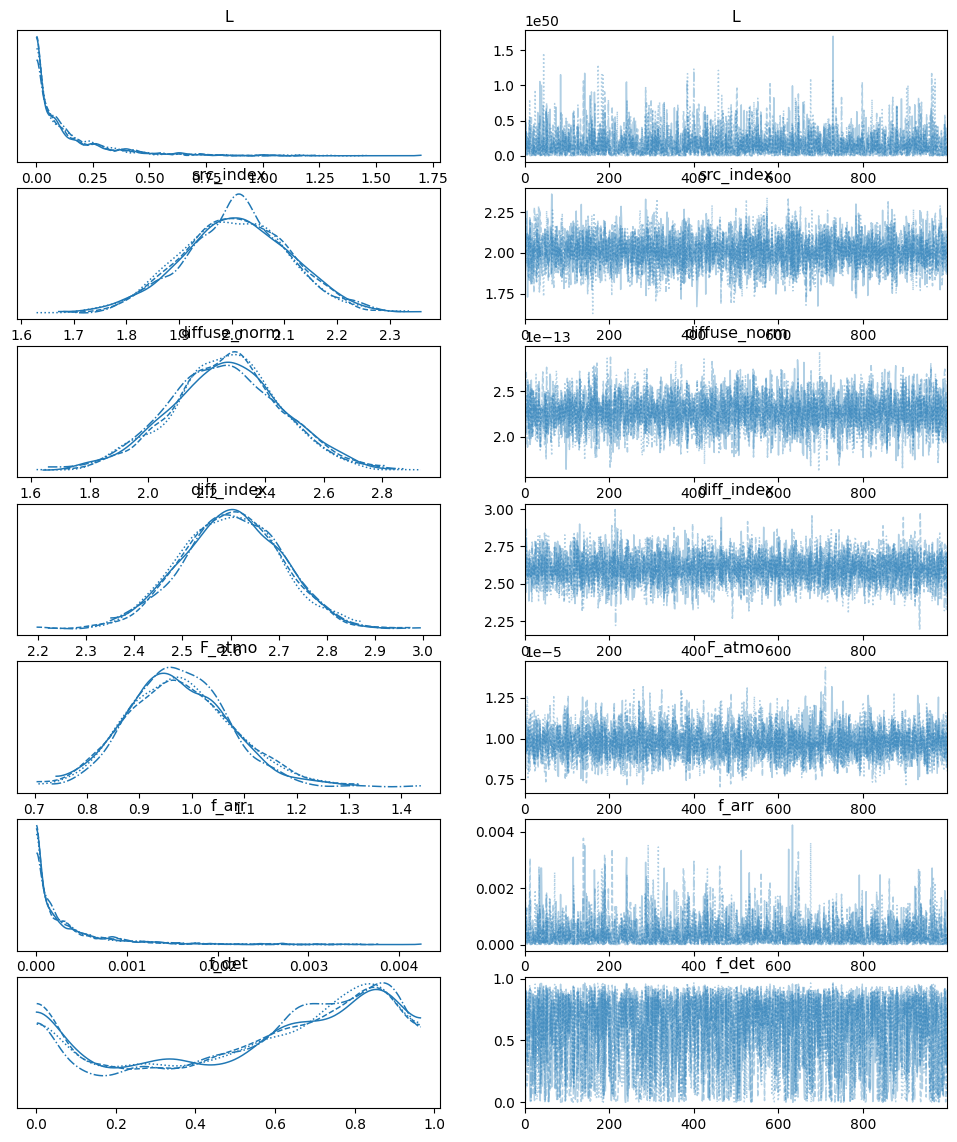

In [30]:
fit.plot_trace()
fig.tight_layout()

In [31]:
from hierarchical_nu.simulation import SimInfo

dict_keys(['L', 'src_index', 'F_diff', 'diff_index', 'F_atmo', 'Ftot', 'f_arr', 'f_arr_astro', 'f_det', 'f_det_astro'])


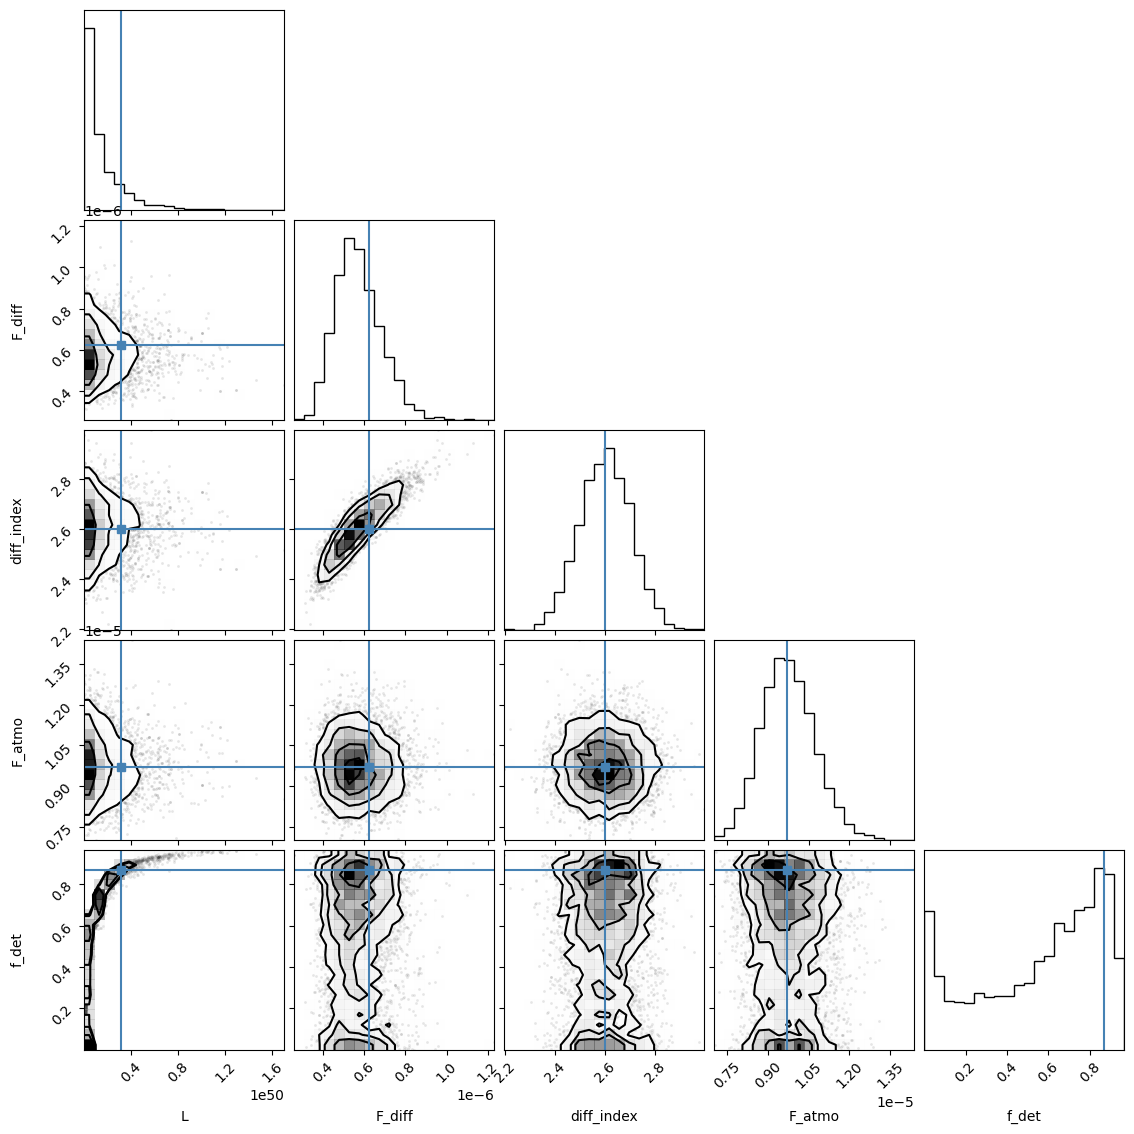

In [32]:
#sim_info = SimInfo.from_file("txs_sim.h5")
#fig = fit.corner_plot(truths=sim_info.truths)
sim_info = SimInfo.from_file("txs_sim.h5")
fig = fit.corner_plot(var_names=["L", "F_diff", "diff_index", "F_atmo", "f_det"], truths=sim_info.truths)
print(sim_info.truths.keys())

In [33]:
_ = fit.check_classification(sim_info.outputs)

All events are correctly classified


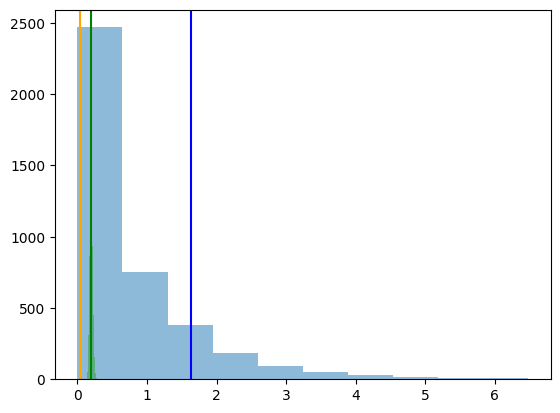

In [34]:
fig, ax = plt.subplots()
ax.hist(fit._fit_output.stan_variable("Nex_src"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_diff"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_atmo"), alpha=0.5)
ax.axvline(sim._expected_Nnu_per_comp[0], color="blue")
ax.axvline(sim._expected_Nnu_per_comp[1], color="orange")
ax.axvline(sim._expected_Nnu_per_comp[2], color="green")

## Fit with similar reconstructed event

In [35]:
from icecube_tools.utils.vMF import get_kappa

In [36]:
sim_info = SimInfo.from_file("txs_sim.h5")
events = Events.from_file("txs_sim.h5")

obs_time = ic_T

labels = sim_info.outputs["Lambda"] - 1
source = np.where(labels==0)[0]
if len(source) != 1:
    print("There is not 1 source event in this event list!")

In [37]:
# IC170922A-like values 
events.energies[source] = ic_Edet
events.ang_errs[source] = 0.7 * u.deg
events.kappas[source] = get_kappa(ic_ang_res.to_value(u.deg), p=0.683)

ic_coord = SkyCoord(ra=ic_ra, dec=ic_dec, distance=1, frame="icrs")
ic_coord.representation_type = "cartesian"
new_coord = SkyCoord(x=ic_coord.x, y=ic_coord.y, z=ic_coord.z, frame="icrs", representation_type="cartesian")
events.coords[source] = new_coord
events.unit_vectors[source][:] = np.array([ic_coord.x, ic_coord.y, ic_coord.z])

"""
rm_idx = np.where(events.energies==np.max(events.energies[labels==1]))[0].squeeze()
labels = np.delete(labels, rm_idx)
events.remove(rm_idx)
"""

events.to_file("txs_ev.h5")

In [38]:
events = Events.from_file("txs_ev.h5")

In [39]:
# Different prior means to try

L_prior_mean = 1e49 * (u.GeV / u.s)
L_prior_width = 3
src_index_prior_mean = 2.0
src_index_prior_width = 0.1

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
#diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
#priors.diffuse_flux = DifferentialFluxPrior(LogNormalPrior, mu=ic_diff_norm, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)
priors.src_index = IndexPrior(mu=src_index_prior_mean, sigma=src_index_prior_width)

In [40]:
import logging

# Locate the specific logger for hierarchical_nu and set it to WARNING
logger = logging.getLogger('hierarchical_nu')
logger.setLevel(logging.WARNING)

# Also disable propagation of DEBUG messages to root logger
logger.propagate = False

#fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10)

fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()

fit.run(show_progress=True, show_console=True, seed=1, iterations=1000, iter_warmup=1000, chains=4)

13:56:37 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
13:57:03 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/caba/examples/.stan_files/model_code
13:57:03 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /tmp/tmprtgpod0w/imaswzmp.json
init = 2 (Default)
random
seed = 1
output
file = /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (Default)


Gradient evaluation took 0.000245 seconds
1000 transitions using 10 leapfrog st

13:57:04 - cmdstanpy - INFO - CmdStan done processing
13:57:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Chain [1] Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain [1] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [1] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.53 seconds (Warm-up)
0.42 seconds (Sampling)
0.95 seconds (Total)




(<Figure size 1200x1400 with 14 Axes>,
 array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
        [<Axes: title={'center': 'src_index'}>,
         <Axes: title={'center': 'src_index'}>],
        [<Axes: title={'center': 'diffuse_norm'}>,
         <Axes: title={'center': 'diffuse_norm'}>],
        [<Axes: title={'center': 'diff_index'}>,
         <Axes: title={'center': 'diff_index'}>],
        [<Axes: title={'center': 'F_atmo'}>,
         <Axes: title={'center': 'F_atmo'}>],
        [<Axes: title={'center': 'f_arr'}>,
         <Axes: title={'center': 'f_arr'}>],
        [<Axes: title={'center': 'f_det'}>,
         <Axes: title={'center': 'f_det'}>]], dtype=object))

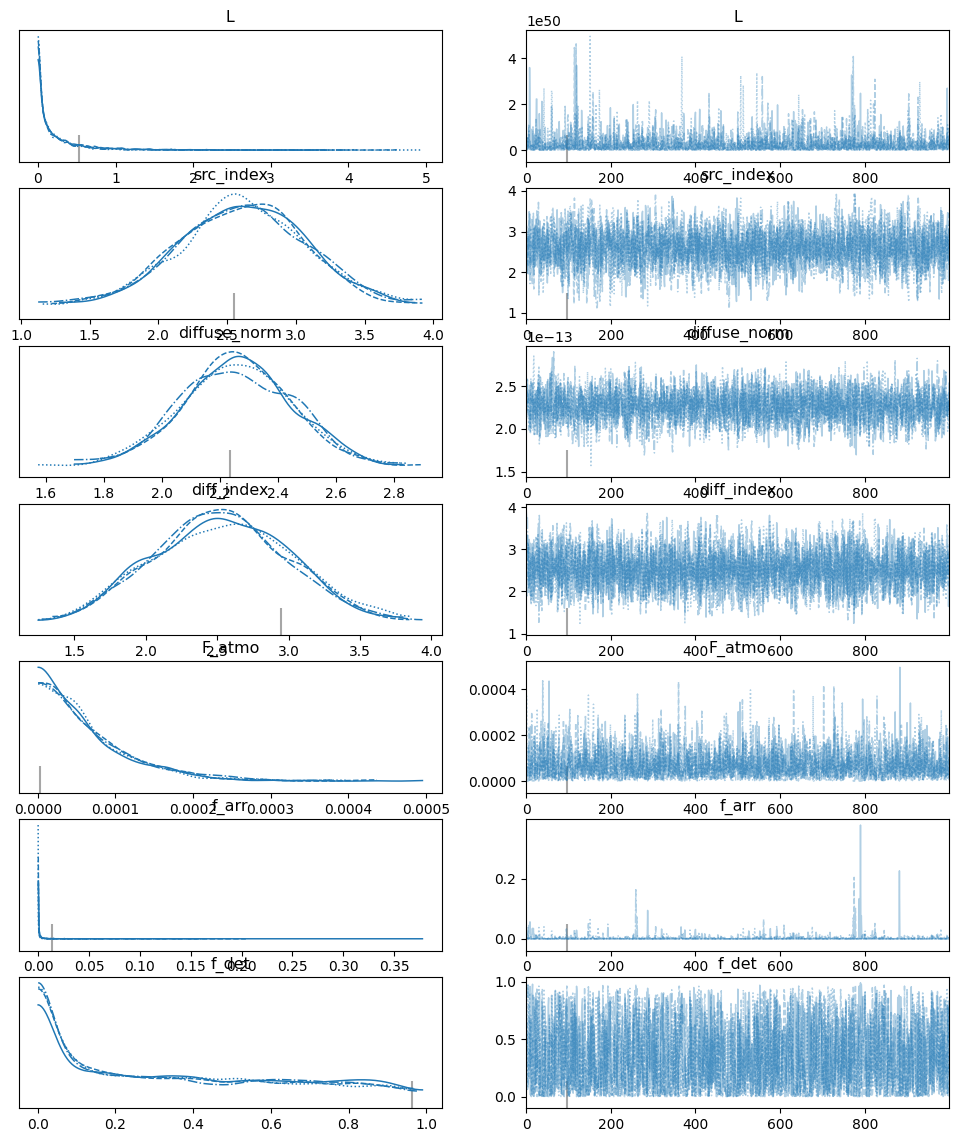

In [41]:
fit.plot_trace()

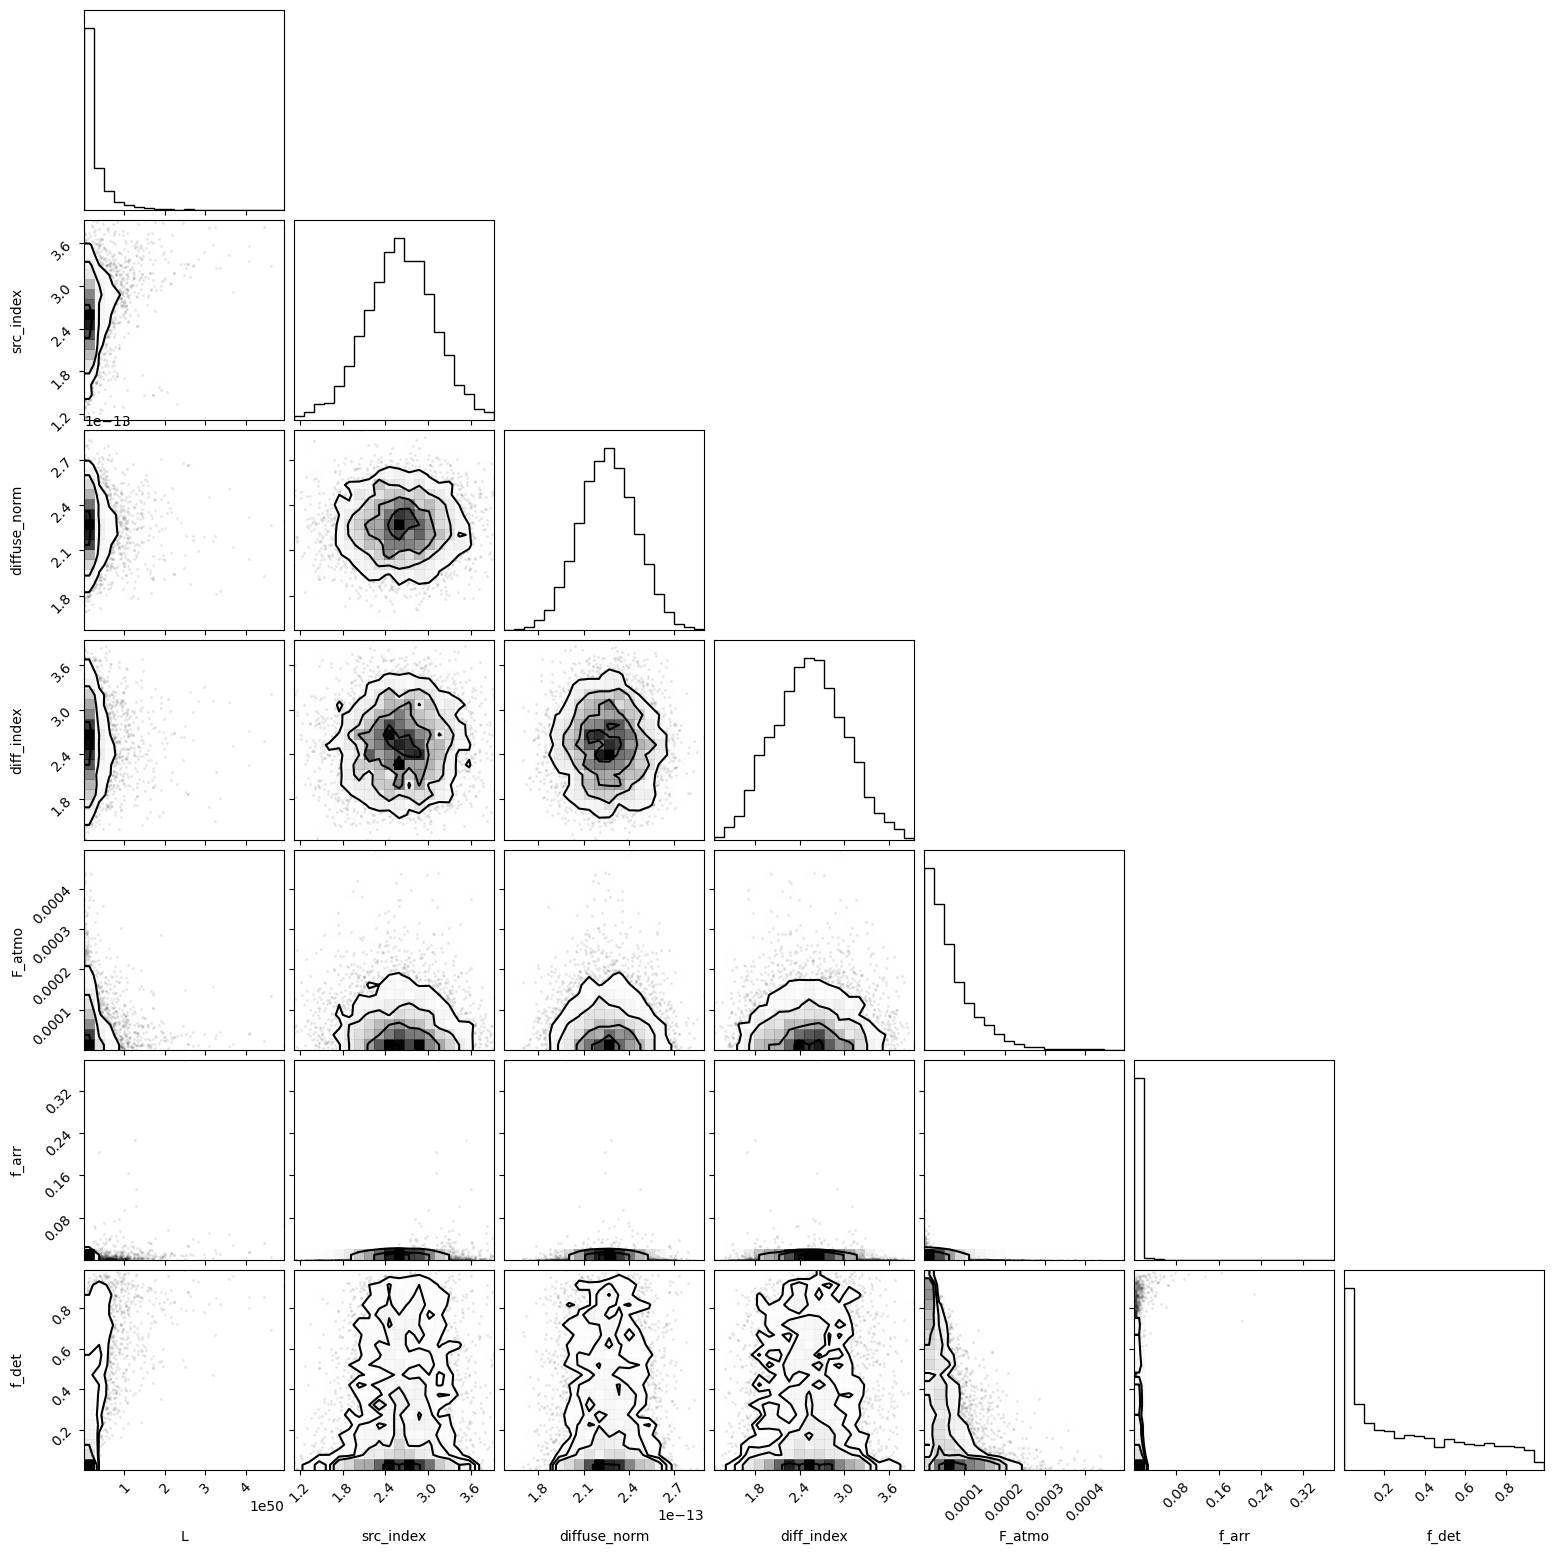

In [42]:
sim_info = SimInfo.from_file("txs_sim.h5")
fig = fit.corner_plot()

In [43]:
# Check association probability
prob_each_src = np.array(fit._get_event_classifications())
p_src = prob_each_src[source].squeeze()[0]
print("Assoc. prob = %.5f" % p_src)
#prob_each_src

Assoc. prob = 0.62402


In [44]:
prob_each_src

array([[0.62401635, 0.01127861, 0.36470504]])

(<Figure size 1200x450 with 3 Axes>,
 [<AstroDegreesZoomAxes: >,
  <Axes: xlabel='$E~[\\mathrm{GeV}]$', ylabel='posterior pdf'>])

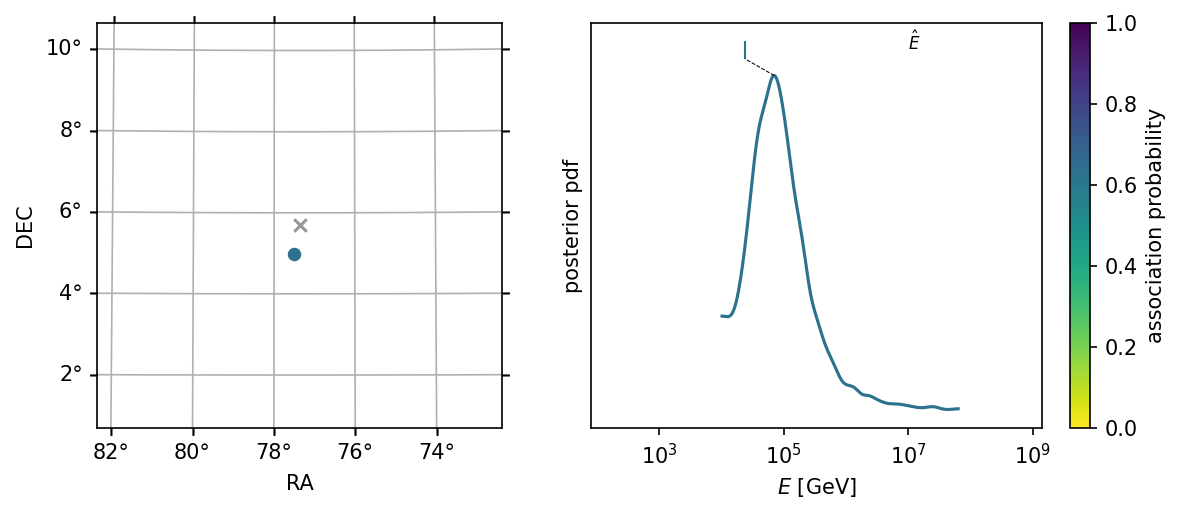

In [45]:
fit.plot_energy_and_roi()

(<Figure size 800x300 with 1 Axes>,
 <Axes: xlabel='$E$ [$\\mathrm{GeV}$]', ylabel='flux [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>)

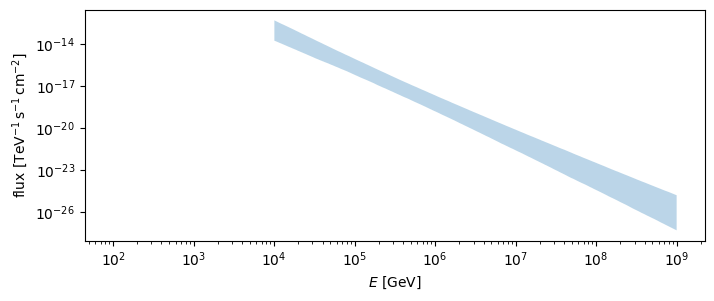

In [46]:
fit.plot_flux_band()

In [47]:
fit.save("fit_powerlaw.h5", overwrite=True)

DEBUG:cmdstanpy:cmd: /home/iwsatlas1/caba/.cmdstan/cmdstan-2.35.0/bin/diagnose /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_1.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_2.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_3.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_4.csv
cwd: None
DEBUG:cmdstanpy:cmd: /home/iwsatlas1/caba/.cmdstan/cmdstan-2.35.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmprtgpod0w/stansummary-model_code-zi2npnfz.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_1.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_2.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_3.csv /tmp/tmprtgpod0w/model_codeyvsu1r4t/model_code-20240926135703_4.csv
cwd: None


PosixPath('/home/iwsatlas1/caba/examples/fit_powerlaw.h5')